In [16]:
import numpy as np
import pandas as pd
from math import sqrt
from keras.models import Sequential
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM

Number of rows where all columns are NaN: 0
Empty DataFrame
Columns: [AverageTemperature, Country]
Index: []
(2073, 2)
            AverageTemperature
dt                            
1841-01-01              -1.100
1841-02-01              -0.079
1841-03-01               2.680
1841-04-01               8.400
1841-05-01              13.796
(2073, 1)


C:\Users\yuta\AppData\Local\Temp\ipykernel_19948\3983915933.py:19: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method='linear', inplace=True)


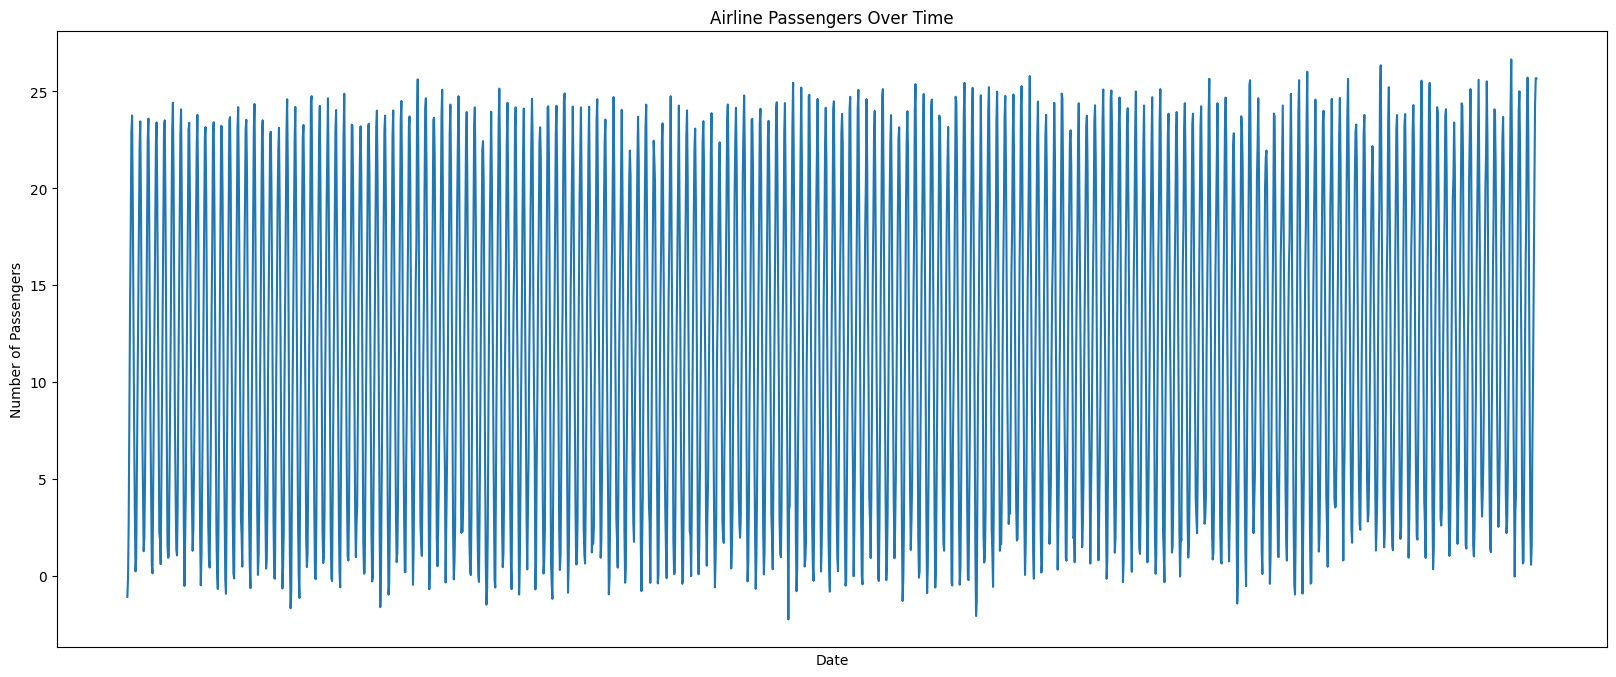

In [17]:
# Load the time series data
df = pd.read_csv("JapanLandTemperature.csv", index_col='dt', parse_dates=True)

# Set the frequency of the DataFrame to the start of the month ('MS').
df = df.asfreq('MS')

# Identify columns that contain the word 'Uncertainty' in their name.
uncertainty_columns = df.filter(like='Uncertainty').columns

# Drop the identified uncertainty columns from the DataFrame.
df = df.drop(columns=uncertainty_columns)

# Filter rows containing all NaN (missing) values
all_nan_rows = df[df.isna().all(axis=1)]

# Interpolate missing values using linear interpolation and modify DataFrame in place
df.interpolate(method='linear', inplace=True)

series = df.drop(columns=['Country'])

print(series.head())

# Print the shape of the dataset (rows, columns)
print(series.shape)

# Plot the time series data with specified figure size
plt.figure(figsize=(20, 8))
plt.plot(series)
plt.title('Airline Passengers Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.xticks([])
plt.show()

In [18]:
# split a univariate dataset into train/test sets
def train_test_split(data, test_size):
    return data[:-test_size], data[-test_size:]

In [19]:
def series_to_supervised(data, n_in, n_out=1):
    """
    Transform a time series into a supervised learning format.
    
    Parameters:
    data (list or array): The univariate time series data.
    n_in (int): The number of lag observations as input (X).
    n_out (int): The number of observations as output (y). Default is 1.
    
    Returns:
    ndarray: The transformed data suitable for supervised learning.
    """
    df = pd.DataFrame(data)
    cols = []

    # Create input sequence (t-n, ..., t-1)
    cols += [df.shift(i) for i in range(n_in, 0, -1)]
    
    # Create forecast sequence (t, t+1, ..., t+n)
    cols += [df.shift(-i) for i in range(n_out)]
    
    # Combine all sequences and drop rows with NaN values
    agg = pd.concat(cols, axis=1).dropna()
    
    return agg.values

In [20]:
print(series_to_supervised(series, 3, 1))

[[-1.1   -0.079  2.68   8.4  ]
 [-0.079  2.68   8.4   13.796]
 [ 2.68   8.4   13.796 18.046]
 ...
 [10.102 15.256 19.961 24.286]
 [15.256 19.961 24.286 25.669]
 [19.961 24.286 25.669 25.669]]


In [21]:
# Fit a model (dummy function, replace with actual model fitting)
def model_fit(train, config):
    return None

# Forecast with a pre-fit model
def model_predict(model, history, offset):
    return history[-offset]

# Calculate root mean squared error (RMSE)
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [22]:
# Walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = []
    # Split dataset into training and test sets
    train, test = train_test_split(data, n_test)
    
    # Fit the model
    model = model_fit(train, cfg)
    # Seed history with the training dataset
    history = list(train)
    
    # Step over each time step in the test set
    for i in range(len(test)):
        # Make forecast for the current history
        yhat = model_predict(model, history, cfg)
        # Store the forecast in the list of predictions
        predictions.append(yhat)
        # Add actual observation to history for the next prediction
        history.append(test[i])
    
    # Estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)
    return error

In [23]:
# Score a model, returning None on failure
def repeat_evaluate(data, config, n_test, n_repeats=10):
    """
    Evaluate a model configuration multiple times and return the average score.
    
    Parameters:
    data (array-like): The dataset for model evaluation.
    config (dict): The model configuration.
    n_test (int): The number of test samples.
    n_repeats (int): The number of times to repeat the evaluation.
    
    Returns:
    tuple: A tuple containing the configuration key and the average score.
    """
    # Convert config to a string key
    key = str(config)
    
    # Fit and evaluate the model n times
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    
    # Calculate and summarize the average score
    result = np.mean(scores)
    print('> Model[%s] %.3f' % (key, result))
    
    return key, result

In [24]:
# Grid search through configurations
def grid_search(data, cfg_list, n_test):
    """
    Perform a grid search to evaluate a list of configurations.
    
    Parameters:
    data (array-like): The dataset for model evaluation.
    cfg_list (list): A list of model configurations to evaluate.
    n_test (int): The number of test samples.
    
    Returns:
    list: A list of tuples with configuration and corresponding error, sorted by error.
    """
    # Evaluate each configuration
    scores = [repeat_evaluate(data, cfg, n_test) for cfg in cfg_list]
    
    # Sort configurations by error in ascending order
    scores.sort(key=lambda tup: tup[1])
    
    return scores

In [25]:
# Define dataset
data = series.values

# Number of test samples: We will use the first 11 years (132 observations) for training and the last 12 for the test set. 
n_test = 12

# Model configurations
cfg_list = [1, 6, 12, 24, 36]

# Perform grid search
scores = grid_search(data, cfg_list, n_test)
print('done')

# List top 10 configurations
for cfg, error in scores[:10]:
    print(cfg, error)

 > 4.567
 > 4.567
 > 4.567
 > 4.567
 > 4.567
 > 4.567
 > 4.567
 > 4.567
 > 4.567
 > 4.567
> Model[1] 4.567
 > 17.354
 > 17.354
 > 17.354
 > 17.354
 > 17.354
 > 17.354
 > 17.354
 > 17.354
 > 17.354
 > 17.354
> Model[6] 17.354
 > 1.180
 > 1.180
 > 1.180
 > 1.180
 > 1.180
 > 1.180
 > 1.180
 > 1.180
 > 1.180
 > 1.180
> Model[12] 1.180
 > 1.588
 > 1.588
 > 1.588
 > 1.588
 > 1.588
 > 1.588
 > 1.588
 > 1.588
 > 1.588
 > 1.588
> Model[24] 1.588
 > 1.362
 > 1.362
 > 1.362
 > 1.362
 > 1.362
 > 1.362
 > 1.362
 > 1.362
 > 1.362
 > 1.362
> Model[36] 1.362
done
12 1.1796118005513507
36 1.362389750891181
24 1.5883320916399482
1 4.567018246806845
6 17.35441715385452


In [26]:
# Difference dataset
def difference(data, order):
    """
    Apply differencing to a dataset.
    
    Parameters:
    data (list or array): The time series data.
    order (int): The lag order to difference by.
    
    Returns:
    list: The differenced dataset.
    """
    return [data[i] - data[i - order] for i in range(order, len(data))]

In [27]:
# Fit a model
def model_fit(train, config):
    """
    Fit a neural network model.
    
    Parameters:
    train (list or array): Training data.
    config (list): Model configuration [n_input, n_nodes, n_epochs, n_batch, n_diff].
    
    Returns:
    model: Trained neural network model.
    """
    # Unpack config
    n_input, n_nodes, n_epochs, n_batch, n_diff = config
    
    # Apply differencing if required
    if n_diff > 0:
        train = difference(train, n_diff)
    
    # Transform series into supervised format
    data = series_to_supervised(train, n_in=n_input)
    
    # Separate inputs and outputs
    train_x, train_y = data[:, :-1], data[:, -1]
    
    # Define and compile the model
    model = Sequential()
    model.add(Dense(n_nodes, activation='relu', input_dim=n_input))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    
    # Fit the model
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    
    return model

In [28]:
# Forecast with the fit model
def model_predict(model, history, config):
    """
    Make a forecast with a trained model.
    
    Parameters:
    model: Trained neural network model.
    history (list): Historical data.
    config (list): Model configuration [n_input, n_nodes, n_epochs, n_batch, n_diff].
    
    Returns:
    float: Forecasted value.
    """
    # Unpack config
    n_input, _, _, _, n_diff = config
    
    # Prepare data
    correction = 0.0
    if n_diff > 0:
        correction = history[-n_diff]
        history = difference(history, n_diff)
    
    # Shape input for the model
    x_input = np.array(history[-n_input:]).reshape((1, n_input))
    
    # Make forecast
    yhat = model.predict(x_input, verbose=0)
    
    # Correct forecast if it was differenced
    return correction + yhat[0]

In [29]:
# Create a list of configs to try
def model_configs():
    """
    Create a list of model configurations to try.
    
    Returns:
    list: List of model configurations.
    """
    # Define scope of configs
    n_input = [12]
    n_nodes = [50, 100]
    n_epochs = [100]
    n_batch = [1, 150]
    n_diff = [0, 12]
    
    # Create configs
    configs = [[i, j, k, l, m] for i in n_input for j in n_nodes for k in n_epochs for l in n_batch for m in n_diff]
    
    print('Total configs: %d' % len(configs))
    return configs

In [31]:
# Define dataset
data = series.values

# Data split
n_test = 12

# Model configs
cfg_list = model_configs()

# Grid search
scores = grid_search(data, cfg_list, n_test)
print('done')

# List top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

Total configs: 8


C:\Users\yuta\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 > 1.265


C:\Users\yuta\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 > 1.294


C:\Users\yuta\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 > 1.270


C:\Users\yuta\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 > 1.468


C:\Users\yuta\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 > 1.265


C:\Users\yuta\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 > 1.270


C:\Users\yuta\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 > 1.241


C:\Users\yuta\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


KeyboardInterrupt: 